<a href="https://colab.research.google.com/github/Madera610/Archivos-IA_y_RD-AGO-DIC-2025-2108162/blob/main/Actividades/AF3_PIA_IAyRN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AF3 PIA: INTELIGENCIA ARTIFICAL Y REDES NEURONALES**

Integrantes:

Blas Eduardo Escobar Rodriguez 1903990 N5

Gael Guevara Puente 2049066 N5

Ana Camila Parra Aguilar 2052187 N5

Christopher Daniel Candelario López 2001039 N5

Jonathan Gonzalez Zuñiga 2108162 N5

# **Explicación de la actividad**

En esta notebook se entrena un modelo de clasificación de imágenes utilizando TensorFlow y Keras en un entorno embebido. La actividad consiste en la creación de un dataset propio balanceado
donde se tomaron fotos de galletas en buen estado, en mal estado y del fondo de donde estarán las galletas,esto con el fin de clasificar correctamente las galletas en buen y mal estado.
También consiste en el entrenamiento de una red neuronal convolucional utilizando la arquitectura MobileNetV2 para optimizar la precisión, y su conversión a formato TensorFlow Lite para ejecución eficiente en el borde (Edge AI). El modelo se integró en un script de Python que gestiona la inferencia en tiempo real, el procesamiento de imagen con OpenCV y el control de periféricos GPIO para la toma de decisiones autónoma.


**1. Configuración del Entorno e Importación de Librerías**
En este paso preparamos el entorno de trabajo.

Gestión de Datos: Descomprimimos el dataset.

Importación de Librerías: Cargamos todas las herramientas necesarias:

*TensorFlow/Keras:* Para la construcción y entrenamiento de la red neuronal.

*NumPy:* Para manipulación de matrices y datos numéricos.

*Matplotlib/Seaborn:* Para la visualización de gráficas y matrices de confusión.

*Sklearn:* Para métricas detalladas de evaluación.

In [ ]:
# 1. CONFIGURACIÓN E IMPORTACIONES
# =====================================================
import os
import zipfile

# Gestión de archivos del sistema
if not os.path.exists('dataset'):
    print("Descomprimiendo dataset...")
    !unzip -q dataset_final_500.zip -d dataset
    print("Dataset listo en la carpeta 'dataset'.")
else:
    print("El dataset ya existe.")

# Importación de Librerías de Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

# Importación de Librerías de Análisis y Visualización
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

print(f" Librerías cargadas. Versión de TensorFlow: {tf.__version__}")

Descomprimiendo dataset...
Dataset listo en la carpeta 'dataset'.
 Librerías cargadas. Versión de TensorFlow: 2.19.0


**2. Preprocesamiento y Generadores de Datos
Configuramos el flujo de datos desde las carpetas hacia el modelo.**

Normalización: Escalamos los píxeles de 0-255 a 0-1 para facilitar el aprendizaje de la red.

Data Augmentation (Aumento de Datos): Aplicamos transformaciones aleatorias (rotación, zoom, brillo) solo al set de entrenamiento. Esto incrementa artificialmente la variedad de datos y ayuda a prevenir el overfitting, haciendo al modelo robusto frente a variaciones.

Validación: Reservamos un 20% de las imágenes para evaluar el modelo durante el entrenamiento.

In [ ]:
# 2. PREPARACIÓN DE DATOS
# =====================================================
IMG_SIZE = (150, 150)
BATCH_SIZE = 16
BASE_DIR = 'dataset'

# Configuración de generador con Aumento de Datos para Entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,      # Rotación aleatoria
    width_shift_range=0.1,  # Desplazamiento horizontal
    height_shift_range=0.1, # Desplazamiento vertical
    shear_range=0.1,        # Inclinación
    zoom_range=0.1,         # Zoom aleatorio
    horizontal_flip=True,   # Espejo horizontal
    brightness_range=[0.7, 1.3], # Variación de iluminación
    validation_split=0.2    # 20% para validación
)

# Generador para Validación (Solo reescalado, sin alteraciones)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

print("Cargando datos...")
# Flujo de datos de entrenamiento
train_gen = train_datagen.flow_from_directory(
    BASE_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Flujo de datos de validación
val_gen = val_datagen.flow_from_directory(
    BASE_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False # Importante: No barajar para poder evaluar la matriz de confusión correctamente
)

# Confirmación de clases
class_indices = train_gen.class_indices
num_classes = len(class_indices)
print(f"\nClases detectadas: {class_indices}")

Cargando datos...
Found 1320 images belonging to 3 classes.
Found 330 images belonging to 3 classes.

Clases detectadas: {'fondo': 0, 'galletas_buenas': 1, 'galletas_malas': 2}


**3. Construcción del Modelo (Transfer Learning)
Diseñamos la arquitectura de la red neuronal:**

Extractor de Características (Base): Utilizamos MobileNetV2 pre-entrenada con ImageNet. Congelamos sus pesos (trainable = False) para conservar el conocimiento previo sobre detección de bordes, texturas y formas.

Clasificador (Cabecera): Añadimos capas personalizadas al final:

GlobalAveragePooling2D: Reduce la dimensionalidad de los mapas de características.

Dense (128): Capa densa para aprender patrones específicos de las galletas.

Dropout (0.3): Apaga neuronas aleatoriamente para evitar la memorización.

Dense (Softmax): Capa de salida con 3 neuronas para clasificar la probabilidad de cada clase.

In [ ]:
# 3. ARQUITECTURA DEL MODELO
# =====================================================

# Cargar la base MobileNetV2 (sin la capa superior "top")
base_model = MobileNetV2(
    input_shape=(150, 150, 3),
    include_top=False,
    weights='imagenet'
)

# Congelar la base
base_model.trainable = False

# Construir el modelo secuencial
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax') # Capa de salida
])

# Compilación
model.compile(
    optimizer=Adam(learning_rate=0.0001), # Learning rate bajo para estabilidad
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/tmp/ipython-input-1438530055.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

**4. Entrenamiento**

Iniciamos el proceso de aprendizaje supervisado. Utilizamos callbacks para optimizar el resultado:

ModelCheckpoint: Guarda  únicamente el modelo que obtenga la mejor precisión en el set de validación, ignorando iteraciones peores.

EarlyStopping: Detiene el entrenamiento si la precisión no mejora después de un número determinado de épocas (paciencia), ahorrando tiempo y recursos.

In [ ]:
# 4. ENTRENAMIENTO
# =====================================================

# Definir Callbacks
checkpoint = ModelCheckpoint(
    'mejor_modelo_galletas.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

earlystop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

print("🚀 Iniciando entrenamiento...")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[checkpoint, earlystop],
    verbose=1
)

🚀 Iniciando entrenamiento...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6829 - loss: 0.7186
Epoch 1: val_accuracy improved from -inf to 0.97273, saving model to mejor_modelo_galletas.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.6843 - loss: 0.7155 - val_accuracy: 0.9727 - val_loss: 0.1138
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9097 - loss: 0.2399
Epoch 2: val_accuracy did not improve from 0.97273
83/83 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.9098 - loss: 0.2395 - val_accuracy: 0.9636 - val_loss: 0.1216
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9408 - loss: 0.1561
Epoch 3: val_accuracy improved from 0.97273 to 0.98788, saving model to mejor_modelo_galletas.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.9408 - loss: 0.1561 - val_accuracy: 0.9879 - val_loss: 0.0626
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9468 - loss: 0.1349
Epoch 4: val_accuracy improved from 0.98788 to 0.99091, saving model to 

**5. Evaluación y Métricas de Desempeño
Para validar la fiabilidad del modelo, analizamos su desempeño en datos no vistos:**

Gráficas: Visualizamos la evolución de la precisión y la pérdida para detectar overfitting o underfitting.

Matriz de Confusión: Nos permite ver exactamente dónde comete errores el modelo (ej. confundir una galleta mala con una buena).

Reporte de Clasificación: Proporciona métricas de Precisión, Recall y F1-Score para cada clase individual.

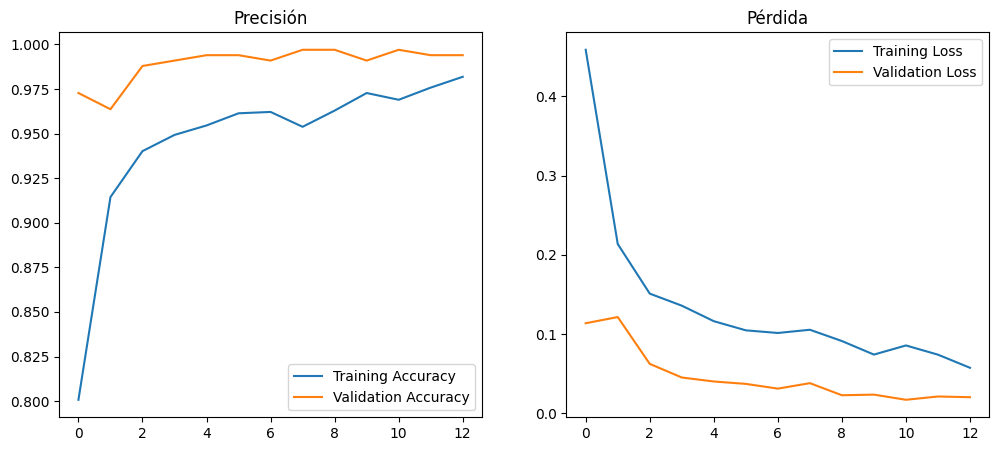


Cargando el mejor modelo para evaluación...
Generando predicciones...
21/21 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step


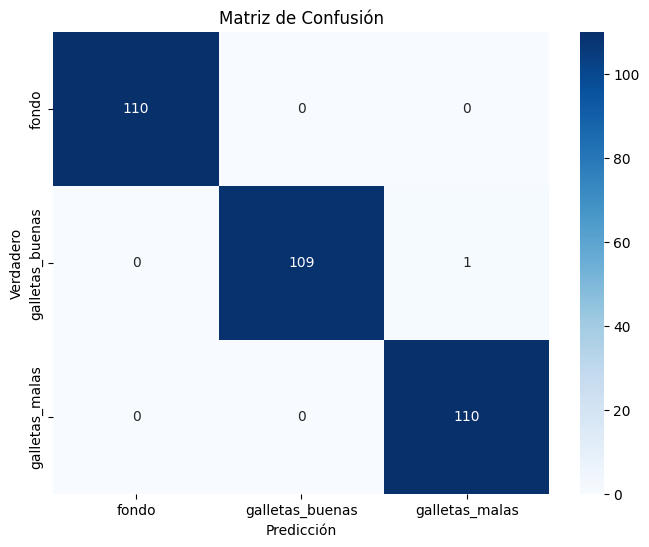


--- REPORTE DE CLASIFICACIÓN ---

                 precision    recall  f1-score   support

          fondo       1.00      1.00      1.00       110
galletas_buenas       1.00      0.99      1.00       110
 galletas_malas       0.99      1.00      1.00       110

       accuracy                           1.00       330
      macro avg       1.00      1.00      1.00       330
   weighted avg       1.00      1.00      1.00       330



In [ ]:
# 5. EVALUACIÓN
# =====================================================

# A) Gráficas de Entrenamiento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Pérdida')
plt.legend()
plt.show()

# B) Cargar el mejor modelo guardado
print("\nCargando el mejor modelo para evaluación...")
best_model = keras.models.load_model('mejor_modelo_galletas.keras')

# C) Generar predicciones
print("Generando predicciones...")
val_gen.reset()
Y_pred = best_model.predict(val_gen, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# D) Matriz de Confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusión')
plt.ylabel('Verdadero')
plt.xlabel('Predicción')
plt.show()

# E) Reporte de Clasificación
print("\n--- REPORTE DE CLASIFICACIÓN ---\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

**6. Exportación (Edge AI)**

Finalmente, convertimos el modelo entrenado al formato TensorFlow Lite (.tflite). Este formato reduce el tamaño del modelo y optimiza las operaciones matemáticas para que pueda ejecutarse eficientemente en dispositivos con recursos limitados, sin perder precisión significativa.

In [ ]:
# 6. EXPORTACIÓN A TFLITE
# =====================================================

# Cargar el modelo Keras optimizado
model = keras.models.load_model('mejor_modelo_galletas.keras')

# Convertir
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Guardar archivo
tflite_filename = 'modelo_galletas_final.tflite'
with open(tflite_filename, 'wb') as f:
    f.write(tflite_model)

print(f" Modelo convertido exitosamente: {tflite_filename}")
print(f"Tamaño del archivo: {os.path.getsize(tflite_filename) / 1024 / 1024:.2f} MB")

# Descarga (Google Colab)
try:
    from google.colab import files
    files.download(tflite_filename)
except ImportError:
    print("Descarga manual requerida.")

Saved artifact at '/tmp/tmpnz7oxe4w'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  140078739315344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140078739309008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140078739317648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140078739316688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140078739316304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140078630880656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140078630880848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140078630879888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140078630880464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140078630881424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1400786308802

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>